# @kanyewest vs @Kantye_West classifier

First let's have a quick look at the datasets provided

In [24]:
%matplotlib inline
import pandas as pd

positive_df = pd.read_json("kanyewest.json")
negative_df = pd.read_json("kantye_west.json")
positive_df.sample(8)

,id,text
564,985700665648394200,still working to get these right https://t.co/...
450,988456198599929900,new ideas will no longer be condemned by the m...
405,989168789378842600,Trav we gotta drop the track with me you and U...
536,986647008176881700,let's be less concerned with ownership of idea...
560,986302853047308300,try to avoid any contractual situation where y...
417,989157843214286800,the Yeezy 350s sell 400 thousand pair in four ...
422,989153539015434200,People magazine. Watch how you speak my name. ...
414,989158715868643300,adidas have been great partners and they've le...


In [25]:
negative_df.sample(8)

,id,text
202,991446184592949200,RT @bycycle: Kanye says he’s tired of McMansio...
152,765749228559794200,Eminem's syllogisms are shit. And he dresses ...
209,984913601143042000,@RollingStone Word?
73,912824985236000800,"@BenWatts92 Hegel, the Sméagol of German idealism"
242,948383861146378200,"@realDonaldTrump Yo, That hairdo looks like it..."
97,870456646073561100,I dont know what's better getting laid or conq...
325,829915517892886500,Donald Trump is the joke \n\nI'm out.
210,984913464584908800,@pitchfork Word?


In [26]:
positive_df.count()

id      575
text    575
dtype: int64

In [27]:
negative_df.count()

id      481
text    481
dtype: int64

## First impressions
* really little data
* classes are fairly balanced. probably don't need to do oversampling
* text is not curated but that may contain strong indication of the fake vs real kanye account
* can we get more data? @kanyewest seems to have deleted his tweeter account. @Kantye_West seems to have less tweets than in the dataset.
* given the domain and including twitter handles, potential vocab can be huge. But then again there's little data which will probably have very few samples from which word
* ideally the parameters of the model shouldn't be more than the size of the training data. But with such little data the model needs to be very simple

## First thought on approaches

#### Simple bag-of-words model
* It's simple and quick to do.
* Little training data, out-of-vocab words will abound (will likely bias to predict the majority class).
* Possibly include 2-grams or tri-grams.
* Include both the normalized text and non-normalized text in the vocab.
* Possibly include subword information alla fast text
* Given the little training data, investigate the vocab size. It may not be good to have a large vocab and main be better to reduce it significantly. E.g. only use words that appear more than X times in the training set.

#### Use the word embedding of each word in the tweet as the input
* Ideally would train a word embedding model on a large amount of tweets
* Could get a pre-trained embedding. If there is none existing for twitter there may be vocab and domain mismatch
* Typically approaches of aggregating (averaging / summing / min / max) the embeddings of the words in the tweet probably will work reasonably but not great
* If one want's to improve on those aggregations probably would need to use a CNN-like approach

#### Other alternatives: probably out of scope
* use CNN on the embedding input
* try non-linear layer(s)
* train a paragraph2vec model on tweets, use the paragraph vectors to train a classifier
* apply unsupervised techniques / dimentionality reduction techniques on tweet text and train the classifier on a internal layer. E.g. autoencoder, DBN, etc.

## Preparing the input

* I'm working under the assumption that text normalization features are important. E.g. puctuation used, caps, etc.
* For now will have a tokenizer that splits on whitespaces and puctuation.
* Will not include the @ in the punctuation list. Most likely it will be used in twitter handles which is an important aspect of the domain to capture.
* Will lowercase the text for now, ideally would model capitalization, e.g. lowercase, capitalized, all_caps, mixed
* Ideally much better processing would be done. It won't be good at capturing things like URLs and definitely won't work on languages like Thai, etc
* Probably emoji should be split as well

In [28]:
import re
import string

class Tokenizer(object):
    SPLIT_RE = re.compile(r"(@\w+|\w+|\S)|[^\s]", re.UNICODE)
    
    @staticmethod
    def split(text):
        return Tokenizer.SPLIT_RE.findall(text.lower())

Tokenizer.split("@ruiaf, does     this; work? 🙌🙌🙌 Hi, maybe")

['@ruiaf',
 ',',
 'does',
 'this',
 ';',
 'work',
 '?',
 '🙌',
 '🙌',
 '🙌',
 'hi',
 ',',
 'maybe']

In [29]:
positive_df['label']=1.0
negative_df['label']=0.0
df = pd.concat([positive_df, negative_df]).sample(frac=1.0)
df['tokenized_text'] = [Tokenizer.split(a) for a in df['text']]
df.sample(8)

,id,text,label,tokenized_text
435,988984329295441900,2024,1.0,[2024]
298,990336500058406900,today is the best day ever and tomorrow's goin...,1.0,"[today, is, the, best, day, ever, and, tomorro..."
203,993628914315546600,https://t.co/y2DHIlfl9Q,1.0,"[https, :, /, /, t, ., co, /, y2dhilfl9q]"
194,684506236210049000,Hegel couldn't get a model for a girlfriend,0.0,"[hegel, couldn, ', t, get, a, model, for, a, g..."
60,991027869957603300,Axel Vervoordt the globe,1.0,"[axel, vervoordt, the, globe]"
349,772161100477530100,Are diamonds a priori ?,0.0,"[are, diamonds, a, priori, ?]"
54,935875580033224700,Thoughts without content are empty. Rhymes wit...,0.0,"[thoughts, without, content, are, empty, ., rh..."
195,989181710787989500,When my daughter acts out she actually says af...,1.0,"[when, my, daughter, acts, out, she, actually,..."


## Preparing the training data

In [30]:
import numpy as np

# I would typically use a validation set to tune hyperparams but
# with so little data it's unlikely we can have relevant hyperparameters
# to tune. In this case it seems like waisting training data.
test_set_share = 0.1

mask = np.random.rand(len(df)) < test_set_share
train_df = df[~mask]
test_df = df[mask]

test_df.sample(8)

,id,text,label,tokenized_text
224,991855983394570200,https://t.co/5smCEzqTmA,1.0,"[https, :, /, /, t, ., co, /, 5smcezqtma]"
469,988140705221496800,https://t.co/ITBf2h71Z3,1.0,"[https, :, /, /, t, ., co, /, itbf2h71z3]"
342,785875146720604200,Donald trump is the David Hume of metaphysica...,0.0,"[donald, trump, is, the, david, hume, of, meta..."
220,992404023197225000,I can’t wait for electric planes. Elon please...,1.0,"[i, can, ’, t, wait, for, electric, planes, .,..."
541,986629639874297900,Be here now. Be in the moment. The now is the ...,1.0,"[be, here, now, ., be, in, the, moment, ., the..."
76,912819324506841100,@la_cosgrove 'The keeping up with the Kardashi...,0.0,"[@la_cosgrove, ', the, keeping, up, with, the,..."
436,424233481057493000,"Therein lies the conflict, after shifting my c...",0.0,"[therein, lies, the, conflict, ,, after, shift..."
421,989153701095915500,now can I get back to my positive vibes 😂😂😂😂😂😂...,1.0,"[now, can, i, get, back, to, my, positive, vib..."


In [31]:
# I'm considering to use the hashing trick instead of having an actual
# vocab. But given the assumption that it may be useful to only consider
# words that have been seen at least X times, it's probably not feasible.
# It would definitely make considering bigrams and subwords easier to handle.
# I'm a big fan of the hashing trick for all the above reasons + it acts like
# regularization.

# Probably other ideas to clean the vocab could be used. E.g. num of distinct tweets. etc
class Vocab(object):
    OOV = 0
    
    def __init__(self, tokenized_tweets, min_num_occurences=0):
        self.word_counts = {}
    
        for tweet in tokenized_tweets:
            for token in tweet:
                if token not in self.word_counts:
                    self.word_counts[token] = 0
                self.word_counts[token] += 1
            
        kept_words = [word for word, count in self.word_counts.items() if count > min_num_occurences]
        kept_words.sort(reverse=True)
        self.words = {}
        for word in kept_words:
            self.words[word] = len(self.words)+1
    
    def __len__(self):
        return len(self.words) + 1
    
    def encode(self, token):
        if token in self.words:
            return self.words[token]
        return self.OOV

vocab_full = Vocab(train_df.tokenized_text)
vocab_clean = Vocab(train_df.tokenized_text, min_num_occurences=2)
print("Full vocab size: %d" % len(vocab_full))
print("Clean vocab size: %d" % len(vocab_clean))

Full vocab size: 2414
Clean vocab size: 787


## Encoding the input with a bag of words approach

In [32]:
class BowEncoder(object):
    def __init__(self, vocab):
        self.vocab = vocab
    
    # encode as a a BoW. Normalize on the length of the tweet
    def encode(self, tokenized_text):
        vec = np.zeros(len(self.vocab))
        for token in tokenized_text:
            vec[self.vocab.encode(token)] += 1.0 / len(tokenized_text)
        return vec

class BowDataset(object):
    def __init__(self, df, min_num_occurences=0, vocab=None):
        self.vocab = vocab if vocab is not None else Vocab(train_df.tokenized_text, min_num_occurences)
        encoder = BowEncoder(self.vocab)
        self.examples = np.array([
            encoder.encode(tokenized_text)
            for tokenized_text in df.tokenized_text])
        self.labels = np.array(df.label, ndmin=2).reshape(-1,1)
    
    def __len__(self):
        return len(self.examples)

trainset_full = BowDataset(train_df)
trainset_clean = BowDataset(train_df, min_num_occurences=2)
testset_full = BowDataset(test_df, min_num_occurences=None, vocab=trainset_full.vocab)
testset_clean = BowDataset(test_df, min_num_occurences=None, vocab=trainset_clean.vocab)

## Baseline models

Let's start by trying two very simple classifiers:
* A simple linear classifier with logloss
* A NN with an internal layer trained on binary cross entropy
* Ignoring regularization for the time being.
* No non-linear layers

In [33]:
import torch

class LinearClassifier(torch.nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.out = torch.nn.Linear(len(vocab), 1)
        # I would normaly apply the sigmoid as part
        # of the loss function for numerical stability purposes
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, in_example):
        return self.sigmoid(self.out(in_example))

    
class SimpleNetClassifier(torch.nn.Module):
    def __init__(self, vocab, inner_layer_size):
        super().__init__()
        self.linear = torch.nn.Linear(len(vocab), inner_layer_size)
        self.out = torch.nn.Linear(inner_layer_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, in_examples):
        return self.sigmoid(
            self.out(self.linear(in_examples)))

models = {}
models['linear_model_vocab_full'] = (LinearClassifier(trainset_full.vocab), trainset_full, testset_full)
models['linear_model_vocab_clean'] = (LinearClassifier(trainset_clean.vocab), trainset_clean, testset_clean)

# Keeping layers small, we already have too many parameters for little input
inner_layer_size = 10
models['simplenet_model_vocab_full'] = (
    SimpleNetClassifier(trainset_full.vocab, inner_layer_size), trainset_full, testset_full)
models['simplenet_model_vocab_clean'] = (
    SimpleNetClassifier(trainset_clean.vocab, inner_layer_size), trainset_clean, testset_clean)

models

{'linear_model_vocab_clean': (LinearClassifier(
    (out): Linear(in_features=787, out_features=1)
    (sigmoid): Sigmoid()
  ),
  <__main__.BowDataset at 0x10dd8edd8>),
 'linear_model_vocab_full': (LinearClassifier(
    (out): Linear(in_features=2414, out_features=1)
    (sigmoid): Sigmoid()
  ),
  <__main__.BowDataset at 0x10dd8eb00>),
 'simplenet_model_vocab_clean': (SimpleNetClassifier(
    (linear): Linear(in_features=787, out_features=10)
    (out): Linear(in_features=10, out_features=1)
    (sigmoid): Sigmoid()
  ),
  <__main__.BowDataset at 0x10dd8edd8>),
 'simplenet_model_vocab_full': (SimpleNetClassifier(
    (linear): Linear(in_features=2414, out_features=10)
    (out): Linear(in_features=10, out_features=1)
    (sigmoid): Sigmoid()
  ),
  <__main__.BowDataset at 0x10dd8eb00>)}

## Training baseline models

In [34]:
class ClassifierTrainer(object):
    def __init__(self, model, train_set, test_set, lr=0.01, momentum=0.5, batch_size=4):
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        self.criterion = torch.nn.BCELoss()
        self.model = model
        self.train_set = train_set
        self.test_set = test_set
        self.batch_size = batch_size
        self.epoch = 0
    
    def train_epoch(self):
        for beg_i in range(0, len(self.train_set), self.batch_size):
            x = torch.autograd.Variable(
                torch.FloatTensor(self.train_set.examples[beg_i:beg_i + self.batch_size, :]))
            y = torch.autograd.Variable(
                torch.FloatTensor(self.train_set.labels[beg_i:beg_i + self.batch_size]))
            
            self.optimizer.zero_grad()
            y_pred = self.model(x)
            loss = self.criterion(y_pred, y)
            loss.backward()
            self.optimizer.step()
         
        self.epoch += 1    
        return {"epoch": self.epoch,
                "train_metrics": self.compute_metrics(self.train_set),
                "test_metrics": self.compute_metrics(self.test_set)}
    
    def compute_metrics(self, dataset):
        x = torch.autograd.Variable(torch.FloatTensor(dataset.examples))
        y = torch.autograd.Variable(torch.FloatTensor(dataset.labels))
        y_pred = self.model(x)
        
        bce = self.criterion(y_pred, y).data[0]
        accuracy = ((y_pred > 0.5).eq(y > 0.5)).type(torch.DoubleTensor).mean().data[0]
        tp = ((y_pred > 0.5).mul(y > 0.5)).type(torch.DoubleTensor).sum().data[0]
        tn = ((y_pred < 0.5).mul(y < 0.5)).type(torch.DoubleTensor).sum().data[0]
        fp = ((y_pred > 0.5).mul(y < 0.5)).type(torch.DoubleTensor).sum().data[0]
        fn = ((y_pred < 0.5).mul(y > 0.5)).type(torch.DoubleTensor).sum().data[0]
        # it would be nice to compute the AUC as well
        
        return [
            ("bce", bce),
            ("accuracy", accuracy),
            ("precision", tp / (tp + fp)),
            ("recall", tp / (tp + fn)),
            ("f1", 2*tp / (2*tp + fp + fn)),
            ]

trainers = {model_name: ClassifierTrainer(model, train_set, test_set)
            for model_name, (model, train_set, test_set) in models.items()}

num_epochs = 100
metrics = []
for epoch in range(num_epochs):
    for trainer in trainers:
        epoch_metrics = (trainer, trainers[trainer].train_epoch())
        metrics.append(epoch_metrics)

metrics_df = pd.DataFrame(columns=['model', 'epoch', 'dataset', 'metric', 'value'])
for model_name, epoch_metrics in metrics:
    epoch = epoch_metrics["epoch"]
    for dataset_name in ["train_metrics", "test_metrics"]:
        for dataset_metrics in epoch_metrics[dataset_name]:
            metrics_df = metrics_df.append({
                'model': model_name,
                'epoch': epoch,
                'dataset': dataset_name,
                'metric': dataset_metrics[0],
                'value': dataset_metrics[1],
            }, ignore_index=True)

metrics_df.set_index(['epoch','metric','dataset'])
metrics_df

,model,epoch,dataset,metric,value
0,linear_model_vocab_full,1,train_metrics,bce,0.682961
1,linear_model_vocab_full,1,train_metrics,accuracy,0.541929
2,linear_model_vocab_full,1,train_metrics,precision,0.541929
3,linear_model_vocab_full,1,train_metrics,recall,1.000000
4,linear_model_vocab_full,1,train_metrics,f1,0.702923
5,linear_model_vocab_full,1,test_metrics,bce,0.679542
6,linear_model_vocab_full,1,test_metrics,accuracy,0.568627
7,linear_model_vocab_full,1,test_metrics,precision,0.568627
8,linear_model_vocab_full,1,test_metrics,recall,1.000000
9,linear_model_vocab_full,1,test_metrics,f1,0.725000


## Evaluation: Are we overfitting?

Let's start by checking for overfitting

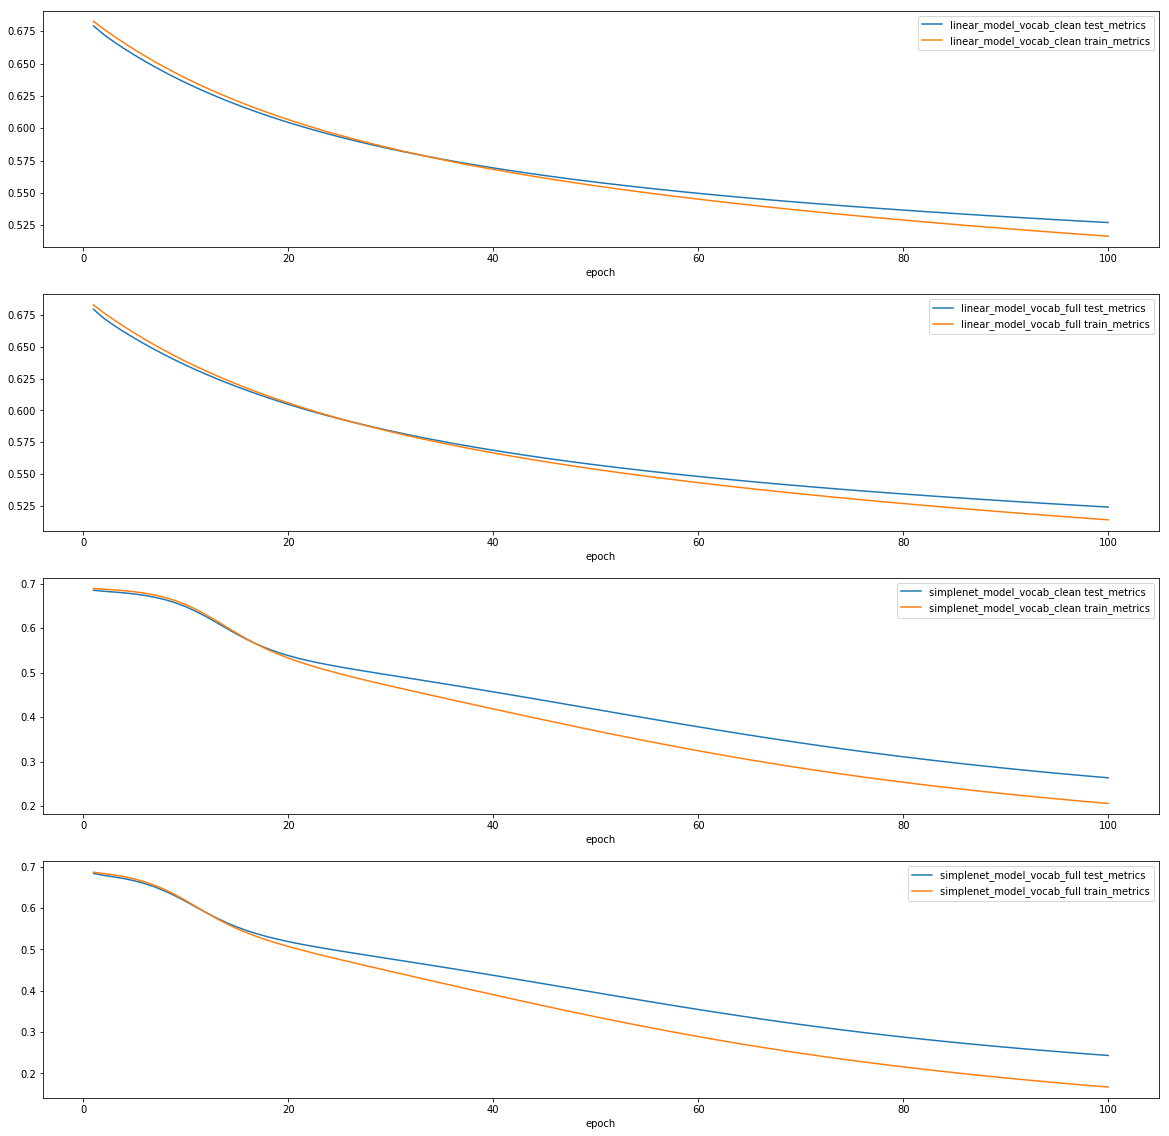

In [35]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, figsize=(20, 20))
i=0
for m, m_grp in metrics_df[metrics_df.metric=='bce'].groupby(['model']):
    for d, d_grp in m_grp.groupby('dataset'):
        d_grp.plot(ax=axes[i], x='epoch', y='value', label="%s %s"%(m,d))
    i += 1

There seems to be a "bit" of overfitting happening.
* Not surprising given that we have no regularization what so ever. Would normally include L2 normalization
* But it doesn't seem to bad in the linear model.
* The SimpleNet (sometimes yes / sometimes no) seems to overfit much more significantly.
* Quality of the SimpleNet seems better
* Tried to rerun a bunch of times and overfitting of the different models changes. Not surprising as he don't have proper initialization

## Evaluation: Quality of the model


### Precision, Recall, f1

In [36]:
metrics_df[(metrics_df.dataset=='test_metrics') & (metrics_df.epoch == 80) & ((metrics_df.metric=='precision') | (metrics_df.metric=='recall') | (metrics_df.metric=='f1'))]

,model,epoch,dataset,metric,value
3167,linear_model_vocab_full,80,test_metrics,precision,0.822222
3168,linear_model_vocab_full,80,test_metrics,recall,0.637931
3169,linear_model_vocab_full,80,test_metrics,f1,0.718447
3177,linear_model_vocab_clean,80,test_metrics,precision,0.822222
3178,linear_model_vocab_clean,80,test_metrics,recall,0.637931
3179,linear_model_vocab_clean,80,test_metrics,f1,0.718447
3187,simplenet_model_vocab_full,80,test_metrics,precision,0.879310
3188,simplenet_model_vocab_full,80,test_metrics,recall,0.879310
3189,simplenet_model_vocab_full,80,test_metrics,f1,0.879310
3197,simplenet_model_vocab_clean,80,test_metrics,precision,0.879310


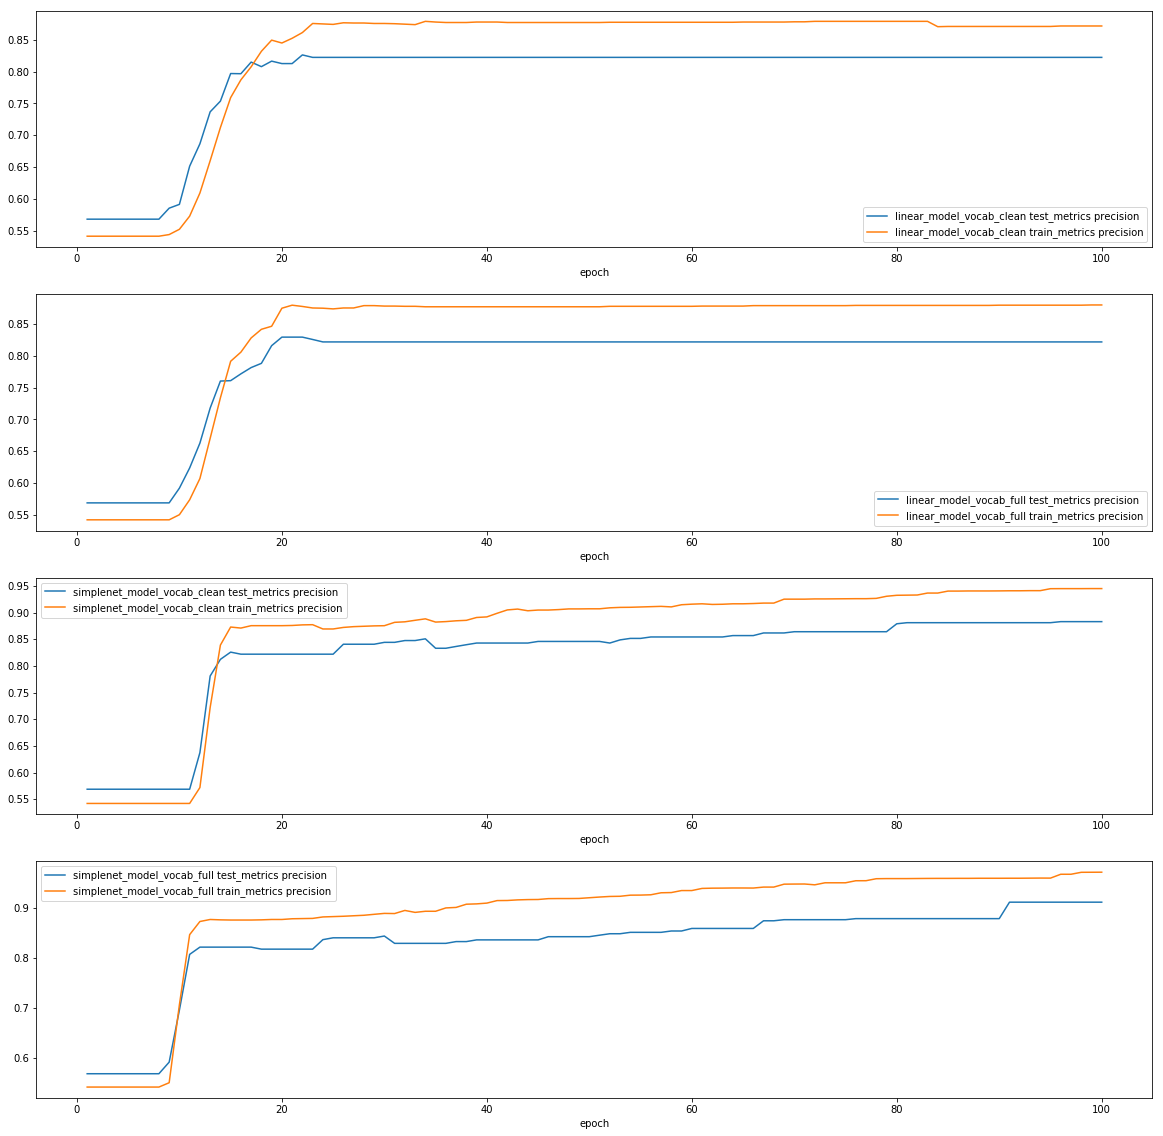

In [37]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, figsize=(20, 20))
i=0
for m, m_grp in metrics_df[metrics_df.metric=='precision'].groupby(['model']):
    for d, d_grp in m_grp.groupby('dataset'):
        d_grp.plot(ax=axes[i], x='epoch', y='value', label="%s %s precision"%(m,d))
    i += 1

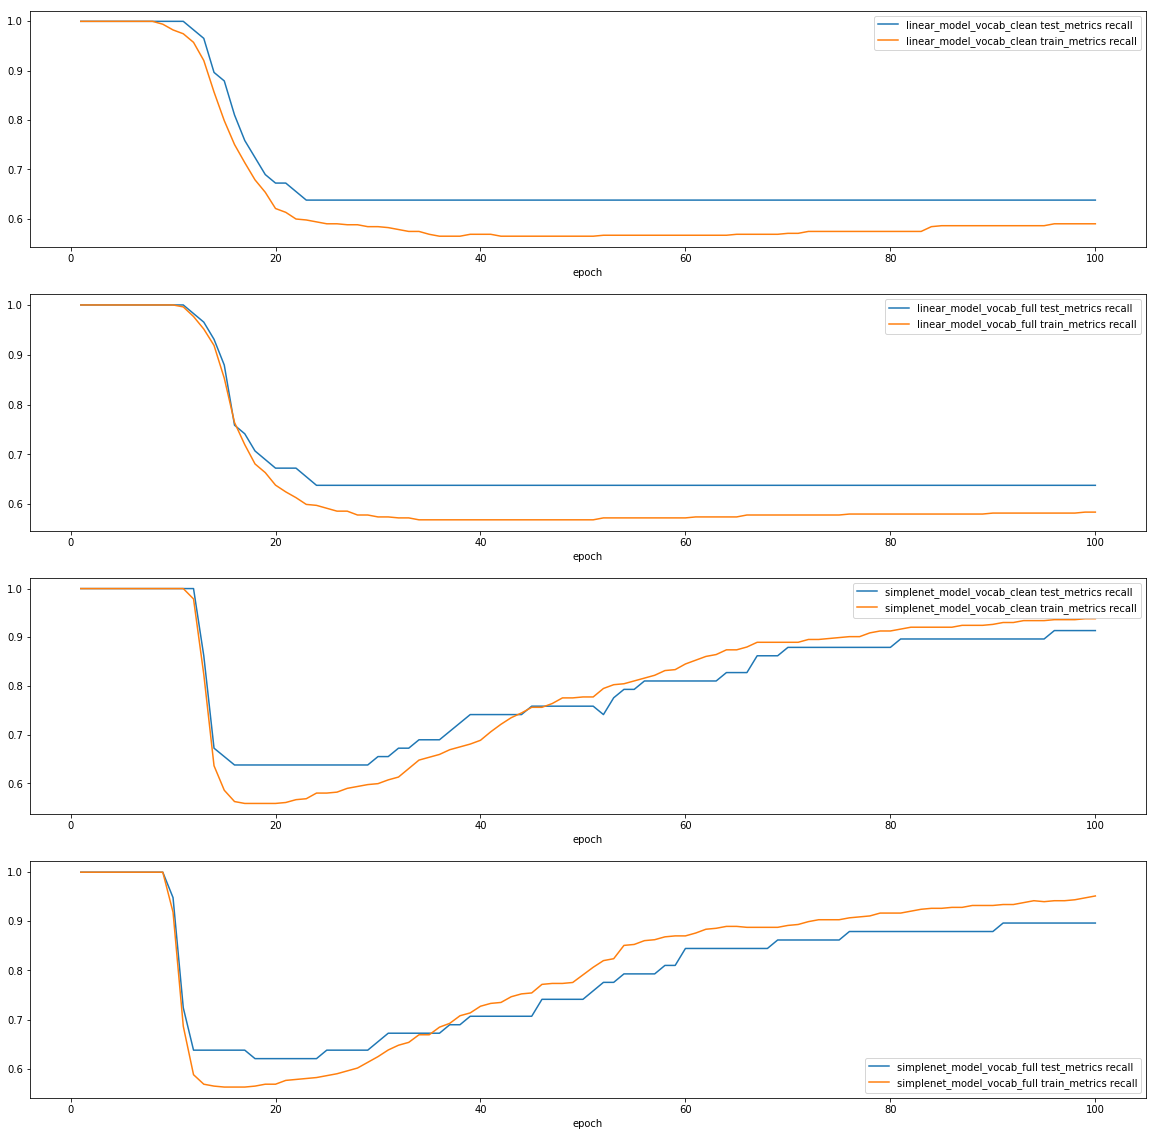

In [38]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, figsize=(20, 20))
i=0
for m, m_grp in metrics_df[metrics_df.metric=='recall'].groupby(['model']):
    for d, d_grp in m_grp.groupby('dataset'):
        d_grp.plot(ax=axes[i], x='epoch', y='value', label="%s %s recall"%(m,d))
    i += 1

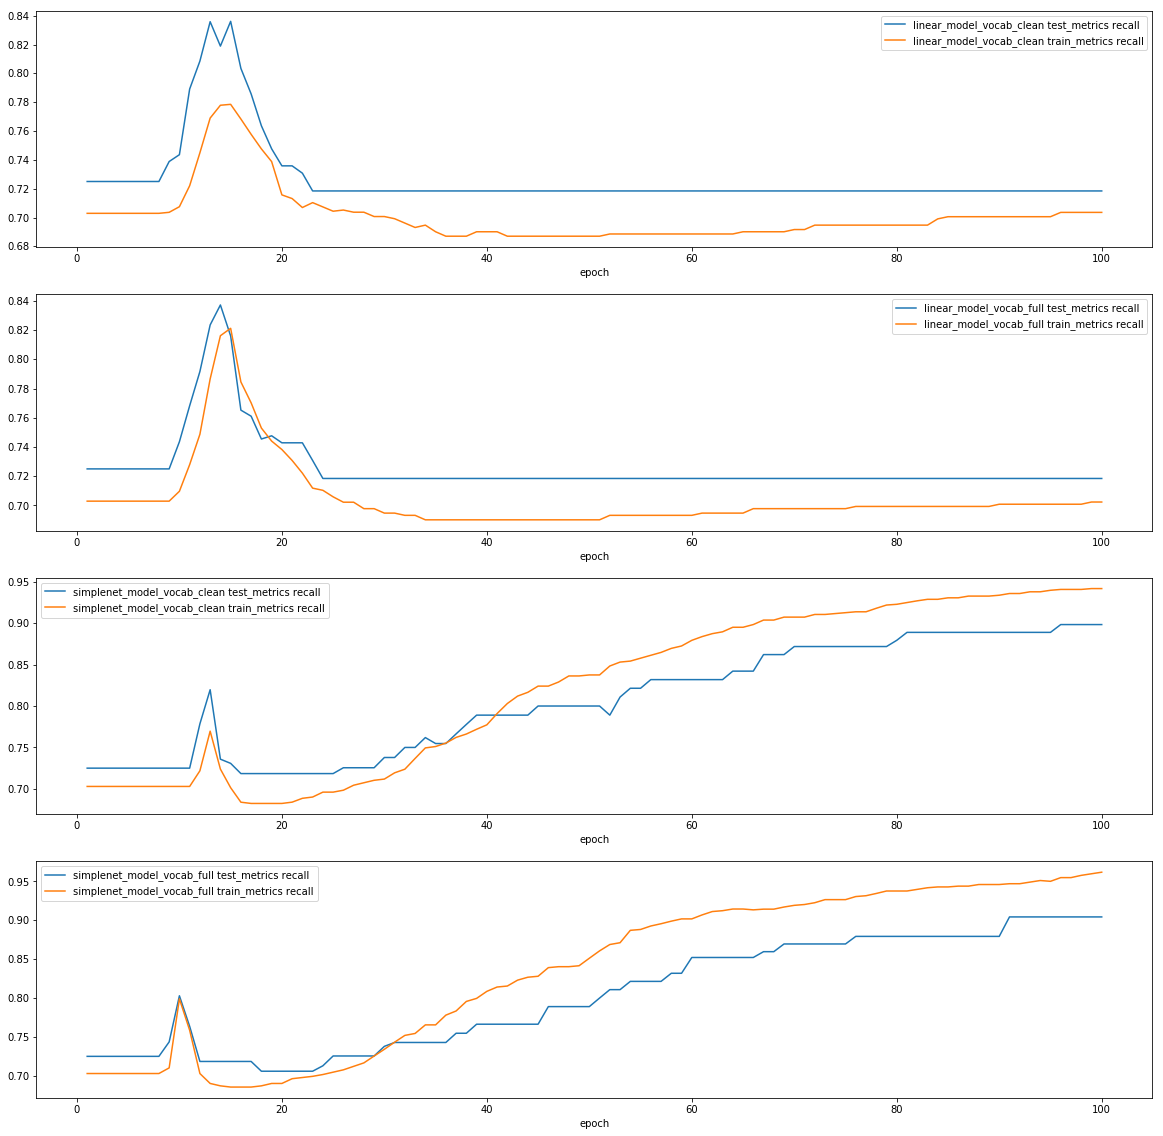

In [39]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, figsize=(20, 20))
i=0
for m, m_grp in metrics_df[metrics_df.metric=='f1'].groupby(['model']):
    for d, d_grp in m_grp.groupby('dataset'):
        d_grp.plot(ax=axes[i], x='epoch', y='value', label="%s %s recall"%(m,d))
    i += 1

## Beyond a baseline model
* Definitely add regularization
* Initialize properly the NN
* I would also try to compare a BOW models with a forest model: random forest or boosted decision trees
* Need to tune the hyperparams: vocab size, learning rate, hidden layer size, etc.
* Use pre-trained embeddings
* See list of initial ideas

# Multi-class version of the problem: Kanye, Kantye, Other
* In terms of models, I would apply similar approaches. Change the loss from BCE to CrossEntropy. Sigmoid to softmax. 3 outputs instead of one.
* It would be an extreme minority class problem. E.g. Given a random tweet, very unlikely that it would belong to any of the 2 handles. There aren't really hopes it would perform well
* If we kind of know that it would be run on tweets from the 2 handles most of the times, there is some hope it would work ok.
* Need to do oversampling of the two classes or undersampling of the 'none of the two' class.

# @KimKardashian vs @KimKierkegaard classifier

In [40]:
positive_df = pd.read_json("KimKardashian.json")
negative_df = pd.read_json("KimKierkegaard.json")
positive_df.sample(8)

,id,text
290,990758021113364500,Rose is one of my favorite scents https://t.co...
2796,909794569218285600,"Allure Cover - ""Best of Beauty"" Issue Thank yo..."
1739,940757683308699600,RT @AsyaKardashian: Mood https://t.co/EhDq1Yx60B
3109,898316344151523300,BFF'S https://t.co/oIzh0vzfBq
1355,959101431973228500,RT @lovekardashhian: KIMOJI HEARTS FRAGRANCES💜...
1261,961661383522713600,The new rules of beauty: there are no rules. C...
3282,888418252308717600,https://t.co/Drb8YB3hZB
1830,937741377982554100,Faux Fur leopard bag https://t.co/BlGB6KQnnV h...


In [41]:
negative_df.sample(8)

,id,text
656,941392250071863300,RT @Chadtronic: I can't believe how this Commi...
290,981733756372385800,"RT @Justinfication: Wow, I’ve seen/heard a lot..."
1130,825080341291532300,RT @Stl_Manifest: My name is Günther Heilbrun....
1358,701240853340229600,My red carpet cleavage secret: Beat your breas...
461,962922902805938200,RT @tigerkite: The must have candles for this ...
481,960162631331008500,I’ve said it on my snapchat &amp; IG stories b...
1634,511002380796960800,RT @tinynietzsche: Pumpkin spice always remind...
1190,808703104426381300,RT @dick_nixon: .@KimKierkegaard Who the hell ...


In [42]:
positive_df.count()

id      3351
text    3351
dtype: int64

In [43]:
negative_df.count()

id      1987
text    1987
dtype: int64

## First impressions
* It seems to be less ballanced that the previous example. Would probably oversample the negatives.
* Slight more data. Still very small and the same problems should happen.

## Let's retrain the models

In [44]:
positive_df['label']=1.0
negative_df['label']=0.0
df = pd.concat([positive_df, negative_df]).sample(frac=1.0)
df['tokenized_text'] = [Tokenizer.split(a) for a in df['text']]
df.sample(8)

,id,text,label,tokenized_text
941,869565345413156900,RT @Seinfeld2000: Pope Your Enthusiasm https:/...,0.0,"[rt, @seinfeld2000, :, pope, your, enthusiasm,..."
1129,967126450255159300,My secret to fuller lips https://t.co/6GkZANRb94,1.0,"[my, secret, to, fuller, lips, https, :, /, /,..."
895,974106979953098800,RT @lifetimetv: Don't miss this rainbow inspir...,1.0,"[rt, @lifetimetv, :, don, ', t, miss, this, ra..."
2082,932130899335921700,RT @AKutieNameKim: #NewProfilePic https://t.co...,1.0,"[rt, @akutienamekim, :, #, newprofilepic, http..."
1314,959532981164503000,Soooo tough! I’m feeling Bae right now! https:...,1.0,"[soooo, tough, !, i, ’, m, feeling, bae, right..."
2261,927353907516280800,RT @GlamourMagUK: If you haven't watched it ye...,1.0,"[rt, @glamourmaguk, :, if, you, haven, ', t, w..."
1380,691057435356852200,RT @BananaKarenina: Herzog voice: Some see cut...,0.0,"[rt, @bananakarenina, :, herzog, voice, :, som..."
2282,926304417489358800,TONIGHT @JimmyKimmelLive https://t.co/mjWNHzaQYL,1.0,"[tonight, @jimmykimmellive, https, :, /, /, t,..."


In [45]:
mask = np.random.rand(len(df)) < test_set_share
train_df = df[~mask]
test_df = df[mask]
trainset_full = BowDataset(train_df)
trainset_clean = BowDataset(train_df, min_num_occurences=2)
testset_full = BowDataset(test_df, min_num_occurences=None, vocab=trainset_full.vocab)
testset_clean = BowDataset(test_df, min_num_occurences=None, vocab=trainset_clean.vocab)
models = {}
models['linear_model_vocab_full'] = (LinearClassifier(trainset_full.vocab), trainset_full, testset_full)
models['linear_model_vocab_clean'] = (LinearClassifier(trainset_clean.vocab), trainset_clean, testset_clean)
models['simplenet_model_vocab_full'] = (
    SimpleNetClassifier(trainset_full.vocab, inner_layer_size), trainset_full, testset_full)
models['simplenet_model_vocab_clean'] = (
    SimpleNetClassifier(trainset_clean.vocab, inner_layer_size), trainset_clean, testset_clean)

trainers = {model_name: ClassifierTrainer(model, train_set, test_set)
            for model_name, (model, train_set, test_set) in models.items()}

num_epochs = 30
metrics = []
for epoch in range(num_epochs):
    for trainer in trainers:
        epoch_metrics = (trainer, trainers[trainer].train_epoch())
        metrics.append(epoch_metrics)

metrics_df = pd.DataFrame(columns=['model', 'epoch', 'dataset', 'metric', 'value'])
for model_name, epoch_metrics in metrics:
    epoch = epoch_metrics["epoch"]
    for dataset_name in ["train_metrics", "test_metrics"]:
        for dataset_metrics in epoch_metrics[dataset_name]:
            metrics_df = metrics_df.append({
                'model': model_name,
                'epoch': epoch,
                'dataset': dataset_name,
                'metric': dataset_metrics[0],
                'value': dataset_metrics[1],
            }, ignore_index=True)

metrics_df.set_index(['epoch','metric','dataset'])
metrics_df

,model,epoch,dataset,metric,value
0,linear_model_vocab_full,1,train_metrics,bce,0.632585
1,linear_model_vocab_full,1,train_metrics,accuracy,0.627734
2,linear_model_vocab_full,1,train_metrics,precision,0.627734
3,linear_model_vocab_full,1,train_metrics,recall,1.000000
4,linear_model_vocab_full,1,train_metrics,f1,0.771298
5,linear_model_vocab_full,1,test_metrics,bce,0.627314
6,linear_model_vocab_full,1,test_metrics,accuracy,0.628049
7,linear_model_vocab_full,1,test_metrics,precision,0.628049
8,linear_model_vocab_full,1,test_metrics,recall,1.000000
9,linear_model_vocab_full,1,test_metrics,f1,0.771536


In [46]:
metrics_df[(metrics_df.dataset=='test_metrics') & (metrics_df.epoch == (num_epochs-1)) & ((metrics_df.metric=='precision') | (metrics_df.metric=='recall') | (metrics_df.metric=='f1'))]

,model,epoch,dataset,metric,value
1127,linear_model_vocab_full,29,test_metrics,precision,0.895973
1128,linear_model_vocab_full,29,test_metrics,recall,0.864078
1129,linear_model_vocab_full,29,test_metrics,f1,0.879736
1137,linear_model_vocab_clean,29,test_metrics,precision,0.900332
1138,linear_model_vocab_clean,29,test_metrics,recall,0.877023
1139,linear_model_vocab_clean,29,test_metrics,f1,0.888525
1147,simplenet_model_vocab_full,29,test_metrics,precision,0.962838
1148,simplenet_model_vocab_full,29,test_metrics,recall,0.922330
1149,simplenet_model_vocab_full,29,test_metrics,f1,0.942149
1157,simplenet_model_vocab_clean,29,test_metrics,precision,0.969072


* linear model seems to work better than on the previous problem, not surprising as we are predicting the majority class. It would probably be worse if we would predict the minority class.
* SimpleNet works only slightly better than before